# Neal Voss
# CSC 7700 Section 1
# Spring 2017
# Final Project

Note: the other notebooks are the same except for minor variations (group by day instead of month, group by day & filter only theft crimes)

Import all necessary modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM
import math

## Part 0: Data Preprocessing

Read in the data using pandas

In [2]:
crimedf=pd.read_csv('crime_mar2017.csv',na_values=['nan'])

/home/mani/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Sample of the data

In [3]:
crimedf.head(5)

,FILE NUMBER,OFFENSE DATE,OFFENSE TIME,CRIME,COMMITTED,OFFENSE,OFFENSE DESC,ADDRESS,ST NUMBER,ST DIR,ST NAME,ST TYPE,CITY,STATE,ZIP,DISTRICT,ZONE,SUBZONE,COMPLETE DISTRICT,GEOLOCATION
0,1.100128e+09,12/09/2011,1450,THEFT,COMMITTED,14:68.4,UNAU USE OF MOTOR VEHICLE,7234 AIRLINE HW,7234.0,NaN,AIRLINE,HW,BATON ROUGE,LA,NaN,1,F,2,1F2,"7234 AIRLINE HW\nBATON ROUGE, LA\n(30.482565, ..."
1,1.400033e+09,04/23/2014,1200,BATTERY,COMMITTED,13:35,BATT/SIMPLE/CC,5900 PEERLESS ST,5900.0,NaN,PEERLESS,ST,BATON ROUGE,LA,NaN,4,D,1,4D1,"5900 PEERLESS ST\nBATON ROUGE, LA\n(30.516849,..."
2,1.200069e+09,07/01/2012,1400,THEFT,COMMITTED,13:67,THEFT/MISD/CC,10250 PLAZA AMERICANA DR,10250.0,NaN,PLAZA AMERICANA,DR,BATON ROUGE,LA,70815,3,C,3,3C3,"10250 PLAZA AMERICANA DR\nBATON ROUGE, LA 7081..."
3,1.400004e+09,01/16/2014,1215,BATTERY,COMMITTED,13:35,BATT/SIMPLE/CC,964 N 48TH,964.0,N,48TH,NaN,BATON ROUGE,LA,70802,NaN,NaN,NaN,NaN,"964 N 48TH\nBATON ROUGE, LA 70802\n(30.457107,..."
4,1.600116e+09,11/21/2016,930,CRIMINAL DAMAGE TO PROPERTY,COMMITTED,14:56,CRIM DAM TO PROP/SIMPLE,5950 ST GERARD AV,5950.0,NaN,ST GERARD,AV,BATON ROUGE,LA,70805,4,F,2,4F2,"5950 ST GERARD AV\nBATON ROUGE, LA 70805\n(30...."


Filter out duplicate entries

In [4]:
crimedf=crimedf.drop_duplicates(['OFFENSE DATE','OFFENSE TIME','GEOLOCATION','CRIME','OFFENSE DESC'])
crimedf.shape

(318523, 20)

Filter out crimes that were only attempted instead of committed

In [5]:
crimedf=crimedf[crimedf['COMMITTED']=='COMMITTED']
crimedf.shape

(311797, 20)

In [6]:
crimedf['OFFENSE DATE']=pd.to_datetime(crimedf['OFFENSE DATE'])

Optional: shorten dataframe to end of 2016

In [7]:
crimedf=crimedf[crimedf['OFFENSE DATE'].dt.year < 2017]
crimedf.shape

(300387, 20)

In [8]:
crimedf.dropna(subset=['CRIME'],inplace=True)
crimedf.shape

(300387, 20)

Create time series by finding crime counts of entries grouped by month

In [9]:
crimegroup=crimedf.groupby(pd.Grouper(key='OFFENSE DATE', freq='M')).count()

In [10]:
crimegroup=crimegroup['CRIME']
crimegroup.head(10)

OFFENSE DATE
2011-01-31    5006
2011-02-28    4532
2011-03-31    5369
2011-04-30    5525
2011-05-31    5679
2011-06-30    5363
2011-07-31    5625
2011-08-31    5125
2011-09-30    4887
2011-10-31    4765
Freq: M, Name: CRIME, dtype: int64

Visualization

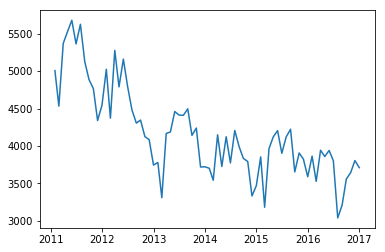

In [11]:
plt.plot(crimegroup)
plt.show()

## Part 1: Time Series Forecasting

For reproducibility

In [12]:
np.random.seed(419)

Create training and testing datasets

In [49]:
train=crimegroup[crimegroup.index.year<2016].values
test=crimegroup[crimegroup.index.year>=2016].values
print(train[:6])
print(test[:6])

[5006 4532 5369 5525 5679 5363]
[3864 3527 3943 3859 3940 3801]


In [50]:
train=np.reshape(train,(-1,1))
test=np.reshape(test,(-1,1))
print(train[:6])

[[5006]
 [4532]
 [5369]
 [5525]
 [5679]
 [5363]]


Create time lag vectors where each entry is of the form X=[t0,t-1,t-2,...t-L],Y=t+1

In [51]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [52]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(55, 4) (55,) (7, 4) (7,)


Compile and train feedforward model

In [53]:
from keras.models import Sequential
from keras.layers import Dense

In [54]:
model = Sequential()
model.add(Dense(look_back, input_dim=look_back, activation='relu'))
model.add(Dense(look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [55]:
h=model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=1,validation_data=(testX,testY))

Train on 55 samples, validate on 7 samples
Epoch 1/200
55/55 [==============================] - 0s - loss: 25074003.3455 - acc: 0.0000e+00 - val_loss: 16077261.4286 - val_acc: 0.0000e+00
Epoch 2/200
55/55 [==============================] - 0s - loss: 20815861.7091 - acc: 0.0000e+00 - val_loss: 13131412.1429 - val_acc: 0.0000e+00
Epoch 3/200
55/55 [==============================] - 0s - loss: 16744781.8909 - acc: 0.0000e+00 - val_loss: 10144096.7143 - val_acc: 0.0000e+00
Epoch 4/200
55/55 [==============================] - 0s - loss: 12400482.2545 - acc: 0.0000e+00 - val_loss: 6898137.5714 - val_acc: 0.0000e+00
Epoch 5/200
55/55 [==============================] - 0s - loss: 7870725.7545 - acc: 0.0000e+00 - val_loss: 3842041.6429 - val_acc: 0.0000e+00
Epoch 6/200
55

Make predictions

In [56]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [57]:
trainPredict=trainPredict.reshape(trainPredict.shape[0])
testPredict=testPredict.reshape(testPredict.shape[0])
print(trainPredict.shape,testPredict.shape)

(55,) (7,)


Calculate root mean squared error

In [58]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 424.09 RMSE
Test Score: 441.22 RMSE


In [59]:
print(testY[0],testPredict[0])

3940 3892.19


Visualization

In [60]:
crimeplot=crimegroup.copy()
print(len(crimeplot))
trainplot=pd.Series(index=crimeplot.index)
testplot=pd.Series(index=crimeplot.index)

72


In [61]:
trainplot[look_back:len(trainPredict)+look_back]=trainPredict
testplot[len(trainPredict)+(look_back*2)+1:len(crimeplot)-1]=testPredict

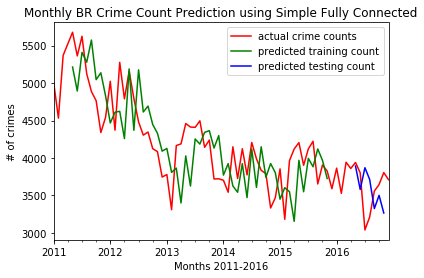

In [63]:
plt.clf()
crimeplot.plot(color='red',label='actual crime counts')
trainplot.plot(color='green',label='predicted training count')
testplot.plot(color='blue',label='predicted testing count')
plt.title('Monthly BR Crime Count Prediction using Simple Fully Connected')
plt.xlabel('Months 2011-2016')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()

# Part 2 testing: LSTM Version

In [27]:
dataset=crimegroup.values
dataset=np.reshape(dataset,(-1,1))

I wanted to experiment with normalization

In [28]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

/home/mani/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Same as before

In [29]:
train2=dataset[0:61,:]
test2=dataset[61:,:]

In [30]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [31]:
look_back2 = 4
train2X, train2Y = create_dataset(train2, look_back2)
test2X, test2Y = create_dataset(test2, look_back2)
train2X.shape

(59, 1)

reshape input to be [samples, time steps, features] which is required for LSTM

In [32]:
train2X = np.reshape(train2X, (train2X.shape[0], 1, train2X.shape[1]))
test2X = np.reshape(test2X, (test2X.shape[0], 1, test2X.shape[1]))

Compile and train LSTM network

In [33]:
model2 = Sequential()
model2.add(LSTM(look_back2, input_shape=(1, look_back2)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
h2=model2.fit(train2X, train2Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.1855
Epoch 2/100
0s - loss: 0.1370
Epoch 3/100
0s - loss: 0.1018
Epoch 4/100
0s - loss: 0.0773
Epoch 5/100
0s - loss: 0.0615
Epoch 6/100
0s - loss: 0.0519
Epoch 7/100
0s - loss: 0.0463
Epoch 8/100
0s - loss: 0.0433
Epoch 9/100
0s - loss: 0.0415
Epoch 10/100
0s - loss: 0.0405
Epoch 11/100
0s - loss: 0.0396
Epoch 12/100
0s - loss: 0.0391
Epoch 13/100
0s - loss: 0.0384
Epoch 14/100
0s - loss: 0.0377
Epoch 15/100
0s - loss: 0.0372
Epoch 16/100
0s - loss: 0.0367
Epoch 17/100
0s - loss: 0.0360
Epoch 18/100
0s - loss: 0.0355
Epoch 19/100
0s - loss: 0.0347
Epoch 20/100
0s - loss: 0.0342
Epoch 21/100
0s - loss: 0.0335
Epoch 22/100
0s - loss: 0.0331
Epoch 23/100
0s - loss: 0.0323
Epoch 24/100
0s - loss: 0.0319
Epoch 25/100
0s - loss: 0.0311
Epoch 26/100
0s - loss: 0.0310
Epoch 27/100
0s - loss: 0.0299
Epoch 28/100
0s - loss: 0.0294
Epoch 29/100
0s - loss: 0.0289
Epoch 30/100
0s - loss: 0.0283
Epoch 31/100
0s - loss: 0.0277
Epoch 32/100
0s - loss: 0.0273
Epoch 33/100
0s -

In [ ]:
Make predictions

In [35]:
train2Predict = model2.predict(train2X)
test2Predict = model2.predict(test2X)

Denormalize to have actual values

In [ ]:
train2Predict = scaler.inverse_transform(train2Predict)
train2Y = scaler.inverse_transform([train2Y])
test2Predict = scaler.inverse_transform(test2Predict)
test2Y = scaler.inverse_transform([test2Y])

In [ ]:
Calculate root mean squared error score

In [36]:
import math
train2Score = math.sqrt(mean_squared_error(train2Y[0], train2Predict[:,0]))
print('Train Score: %.2f RMSE' % (train2Score))
test2Score = math.sqrt(mean_squared_error(test2Y[0], test2Predict[:,0]))
print('Test Score: %.2f RMSE' % (test2Score))

Train Score: 359.77 RMSE
Test Score: 306.48 RMSE


In [37]:
print(train2Y.shape,train2Predict.shape)
train2Predict=train2Predict.reshape(train2Predict.shape[0])
test2Predict=test2Predict.reshape(test2Predict.shape[0])

(1, 59) (59, 1)


Visualize

In [38]:
train2plot=pd.Series(index=crimeplot.index)
test2plot=pd.Series(index=crimeplot.index)
train2plot[look_back2:len(train2Predict)+look_back2]=train2Predict
test2plot[len(train2Predict)+(look_back2*2)+1:len(crimeplot)-1]=test2Predict

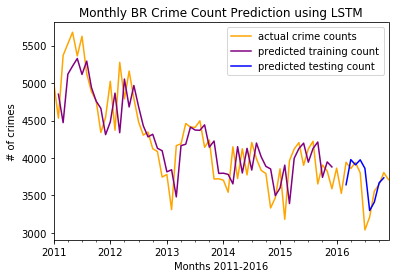

In [39]:
plt.clf()
crimeplot.plot(color='orange',label='actual crime counts')
train2plot.plot(color='purple',label='predicted training count')
test2plot.plot(color='blue',label='predicted testing count')
plt.title('Monthly BR Crime Count Prediction using LSTM')
plt.xlabel('Months 2011-2016')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()

## Part 3: ARIMA

In [40]:
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

Autocorrelation plot used to identify best time window

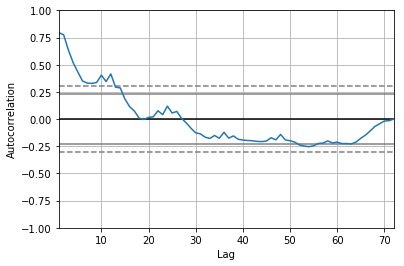

In [41]:
autocorrelation_plot(crimegroup)
plt.show()

In [42]:
crimegroup.dtype
acrimegroup=crimegroup.astype(np.float64)

Define ARIMA model with p=4,d=1,q=0

In [43]:
#fit ARIMA model to crime series
look_back3=4
amodel=ARIMA(acrimegroup,order=(look_back3,1,0))
amodel_fit=amodel.fit(disp=0)
print(amodel_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.CRIME   No. Observations:                   71
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -511.135
Method:                       css-mle   S.D. of innovations            322.909
Date:                Thu, 04 May 2017   AIC                           1034.270
Time:                        16:48:57   BIC                           1047.846
Sample:                    02-28-2011   HQIC                          1039.669
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.1863     25.427     -0.715      0.477     -68.021      31.649
ar.L1.D.CRIME    -0.4190      0.116     -3.626      0.001      -0.645      -0.193
ar.L2.D.CRIME     0.1042      0.132     

Plot residual errors

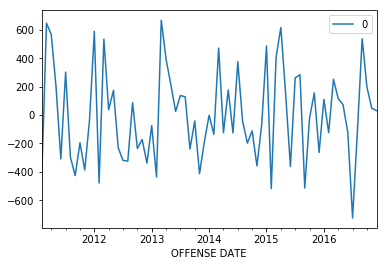

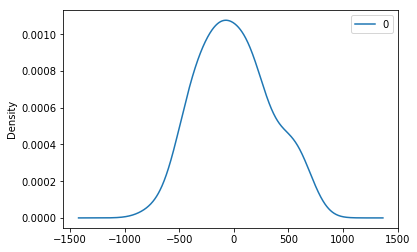

                0
count   71.000000
mean    -0.756559
std    326.994076
min   -724.570069
25%   -237.339737
50%    -34.828487
75%    197.379308
max    668.401159


In [44]:
residuals=pd.DataFrame(amodel_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Full model with predictions

predicted=3514.816973, expected=3470.000000
predicted=3356.121932, expected=3854.000000
predicted=3634.408478, expected=3181.000000
predicted=3476.951598, expected=3964.000000
predicted=3498.105849, expected=4120.000000
predicted=4020.978000, expected=4205.000000
predicted=4144.458986, expected=3902.000000
predicted=4025.116632, expected=4121.000000
predicted=3991.415591, expected=4223.000000
predicted=4155.653543, expected=3653.000000
predicted=3904.919463, expected=3906.000000
predicted=3754.895348, expected=3825.000000
predicted=3838.588962, expected=3589.000000
predicted=3673.501109, expected=3864.000000
predicted=3701.965875, expected=3527.000000
predicted=3664.385978, expected=3943.000000
predicted=3706.476743, expected=3859.000000
predicted=3877.856949, expected=3940.000000
predicted=3877.318479, expected=3801.000000
predicted=3847.339076, expected=3039.000000
predicted=3376.244222, expected=3210.000000
predicted=3090.731698, expected=3558.000000
predicted=3364.794400, expected=

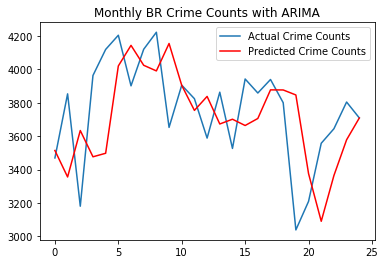

In [45]:
X=acrimegroup.values
p=1
size=int(len(X)*0.66)
atrain, atest=X[0:size],X[size:len(X)]
history=[x for x in atrain]
predictions=list()
for t in range(len(atest)):
    amodel=ARIMA(history,order=(p,1,0))
    amodel_fit=amodel.fit(disp=0)
    output=amodel_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=atest[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error=math.sqrt(mean_squared_error(atest,predictions))
print('Test RMSE: %.3f' % error)
#plot
plt.plot(atest, label='Actual Crime Counts')
plt.plot(predictions,color='red',label='Predicted Crime Counts')
plt.title('Monthly BR Crime Counts with ARIMA')
plt.legend(loc='upper right')
plt.show()

In [46]:
atest.shape

(25,)

Visualization

In [47]:
arimaplot=pd.Series(index=crimeplot.index)
arimaplot[len(crimeplot)-len(predictions):]=predictions

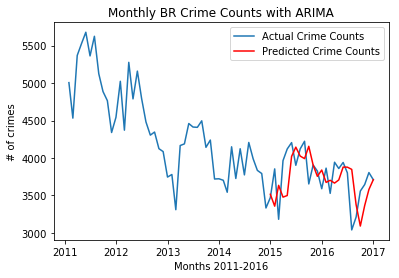

In [48]:
plt.plot(crimeplot, label='Actual Crime Counts')
plt.plot(arimaplot,color='red',label='Predicted Crime Counts')
plt.title('Monthly BR Crime Counts with ARIMA')
plt.xlabel('Months 2011-2016')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()